<a href="https://colab.research.google.com/github/vectice/vectice-examples/blob/master/Sagemaker/InsuranceClaim_Sagemaker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preparation

Welcome to the Vectice Insurance Claim Predictions notebook!

Through this notebook, we will be illustrating how to log the following information into Vectice using the Vectice Python library:
- Dataset versions
- Model versions
- Runs and lineage

### Install Vectice

In [ ]:
#Install Vectice Python library 
# In this notebook we will do code versioning using github, we also support gitlab
# and bitbucket: !pip install -q "vectice[github, gitlab, bitbucket]"
!pip install --q vectice[github]==2.2.3

In [ ]:
#Verify if Vectice python library was installed
!pip3 show vectice

## Getting the data from S3

Here, the our data is stored in Amazon S3. We should install the following S3 packages in order to be able to get it.

In [ ]:
## S3 file system package
!pip3 install --q s3fs
## Upgrade pandas
!pip3 install --q --upgrade pandas

We are going to load data stored in Amazon S3, that is provided by Vectice for this notebook.

- If you're using Sagemaker studio with access to your data on S3 or if your data is public, you can read it by using pd.read_csv(The S3 URI of your file)
- If you're using Sagemaker studio without access to your data on S3, you have to authenticate to be able to retrieve your data from S3. For more information, check the [documentation](https://doc.vectice.com/integration/aws.html#amazon-s3)

In [ ]:
!pip3 install -q matplotlib
!pip3 install -q seaborn
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

df = pd.read_csv('s3://vectice-examples/Tutorial/insurance.csv')
df = df.rename(columns={"sex": "gender", "bmi": "health_score", "smoker": "pre_condition"})
# removing the column Region as it is not of our best interest
df = df.drop('region', axis = 1)

# Run head to make sure the data was loaded properly
df.head()

,age,gender,health_score,children,pre_condition,charges
0,19,female,27.900,0,yes,16884.92400
1,18,male,33.770,1,no,1725.55230
2,28,male,33.000,3,no,4449.46200
3,33,male,22.705,0,no,21984.47061
4,32,male,28.880,0,no,3866.85520


We will use the scikit-learn library for modeling and tracking experiments directly through the Vectice Python library.

In [ ]:
#Import the Vectice library
from vectice import Experiment
from vectice.api.json import JobType
from vectice.api.json import ModelType
import logging
logging.basicConfig(level=logging.INFO)

# Specify the API endpoint for Vectice.
os.environ['VECTICE_API_ENDPOINT']= "app.vectice.com"

# To use the Vectice Python library, you first need to authenticate your account using an API token.
# You can generate an API token from the Vectice UI, by going to the "API Tokens" section in the "My Profile" section
# which is located under your profile picture.
# You can specify your API Token here in the notebook, but we recommend you to add it to a .env file
os.environ['VECTICE_API_TOKEN'] = "Your API Token"

# Next, you need to specify the project where you will run this notebook using a 
# The project id. You can find your project id in the project settings in the UI. It sould be an int. 
project_id = ID

### Exploratory Data Analysis

Let's see how is the data distribution and understand the impact for each feature!

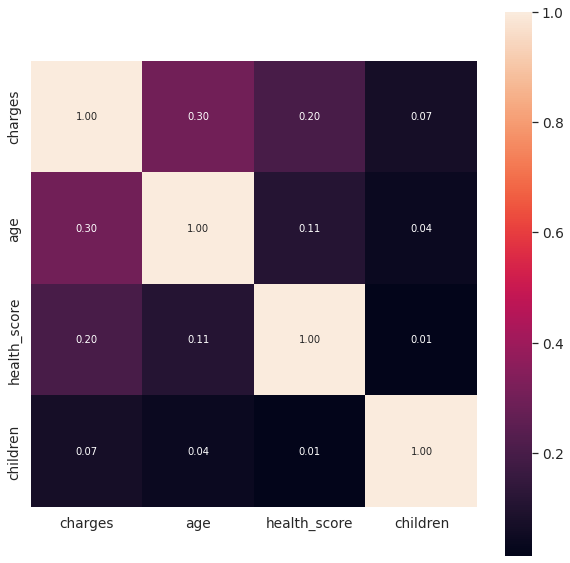

<Figure size 432x288 with 0 Axes>

In [ ]:
# Correlation

plt.figure(figsize = (10, 10))
corrmat = df.corr()
k = 4 #number of variables for heatmap
cols = corrmat.nlargest(k, 'charges')['charges'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()
plt.savefig("Correlation_Heatmap.png")

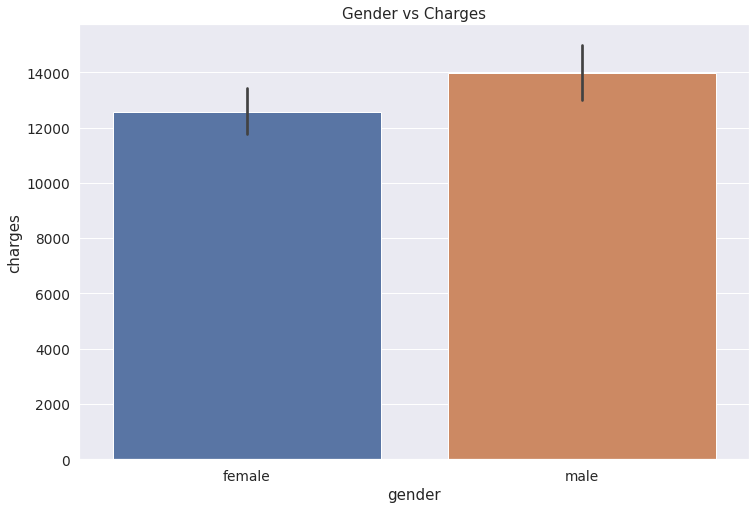

In [ ]:
# Plotting Box Plots for --
plt.figure(figsize = (12, 8))
sns.barplot(x = 'gender', y = 'charges', data = df)
plt.title("Gender vs Charges")
plt.savefig("Gender.png")

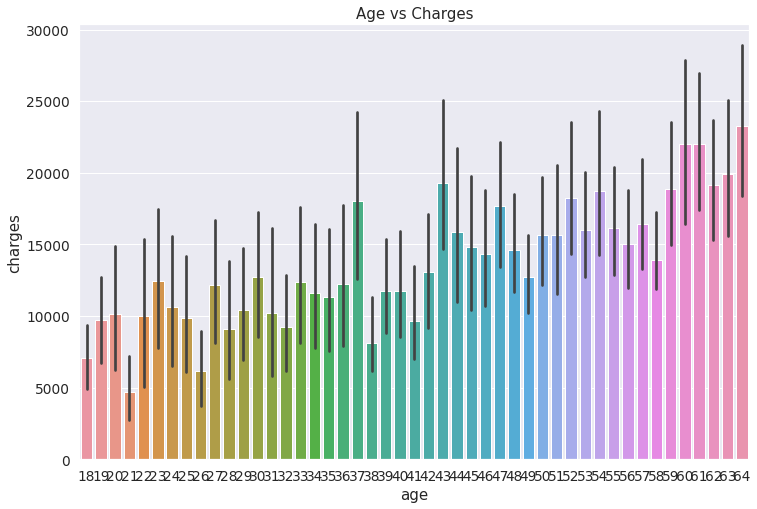

In [ ]:
# Plotting Box Plots for --
plt.figure(figsize = (12, 8))
sns.barplot(x = 'age', y = 'charges', data = df)
plt.title("Age vs Charges")
plt.savefig("Age.png")

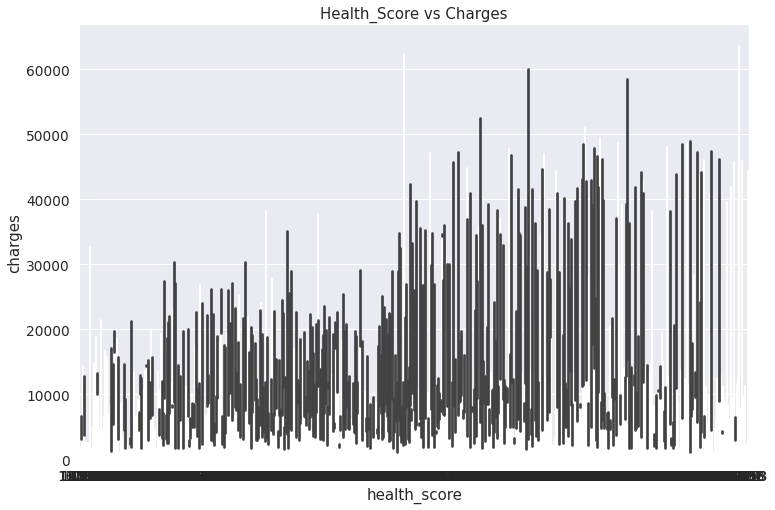

In [ ]:
# Plotting Box Plots for --
plt.figure(figsize = (12, 8))
sns.barplot(x = 'health_score', y = 'charges', data = df)
plt.title("Health_Score vs Charges")
plt.savefig("HealthScore.png")

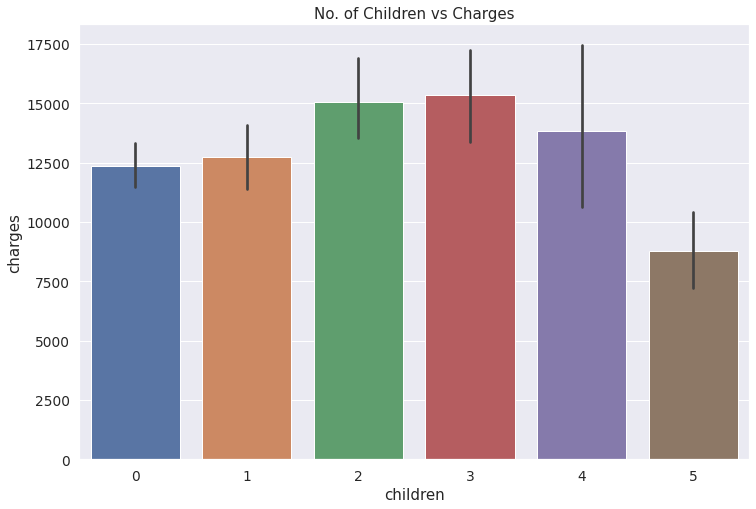

In [ ]:
# Plotting Box Plots for --
plt.figure(figsize = (12, 8))
sns.barplot(x = 'children', y = 'charges', data = df)
plt.title("No. of Children vs Charges")
plt.savefig("Children.png")

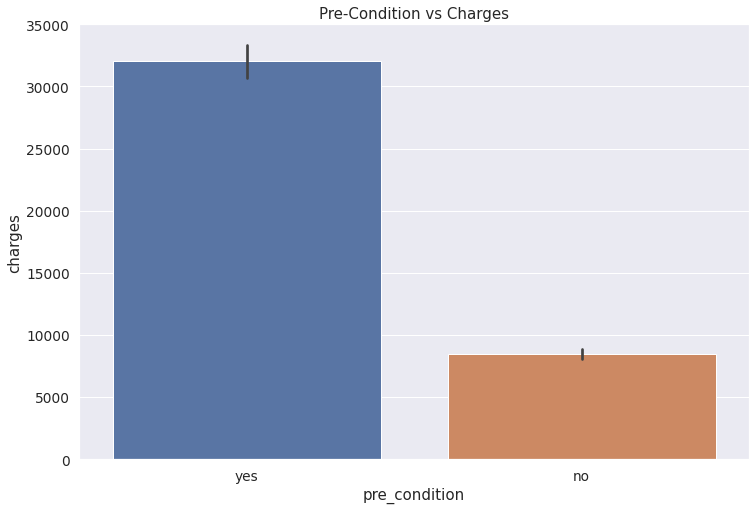

In [ ]:
# Plotting Box Plots for --
plt.figure(figsize = (12, 8))
sns.barplot(x = 'pre_condition', y = 'charges', data = df)
plt.title("Pre-Condition vs Charges")
plt.savefig("PreCondition.png")

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['gender'] = le.fit_transform(df['gender'])
df['pre_condition'] = le.fit_transform(df['pre_condition'])
df.head()

,age,gender,health_score,children,pre_condition,charges
0,19,0,27.900,0,1,16884.92400
1,18,1,33.770,1,0,1725.55230
2,28,1,33.000,3,0,4449.46200
3,33,1,22.705,0,0,21984.47061
4,32,1,28.880,0,0,3866.85520


We will use the scikit-learn library for modeling and tracking experiments directly through the Vectice Python library.

In [ ]:
import string
from math import sqrt
# Load scikit-learn packages
from sklearn.model_selection import train_test_split  # Model Selection
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score  # Model Evaluation
from sklearn.linear_model import LinearRegression  # Linear Regression
from sklearn.tree import DecisionTreeRegressor, plot_tree  # Decision Tree Regression
from sklearn.ensemble import RandomForestRegressor  # Random Forest Regression


### Split dataset into training and testing

Let's split the dataset into train and test sets and save them in S3.
(The S3 code has been commented out as the data has already been generated). For this section, we will re-use some datasets that have been already created to illustrate dataset versioning.


In [ ]:
# We create our first experiment for data preparation and specify the workspace and the project we will be working on
# Each experiment only contains one job. Each invokation of the job is called a run.
# autocode = True enables you to track your git changes for your code automatically every time you execute a run (see below).
experiment = Experiment(job="80/20 Split", job_type = JobType.PREPARATION, project=project_id, auto_code = True)

We can get the list of the datasets existing in our project by calling **experiment.list_datasets()**.


In [ ]:
experiment.list_datasets()

[Dataset(name=test_cleaned_insurance_claim_data, id=1899, description=None, connection=None, resources=None),
 Dataset(name=train_cleaned_insurance_claim_data, id=1898, description=None, connection=None, resources=None),
 Dataset(name=cleaned_insurance_claim_data, id=1897, description=None, connection=None, resources=None)]

In [ ]:
# The Vectice library automatically detects if there have been changes to the dataset you are using.
# If it detects changes, it will generate a new version of your dataset automatically. 

input_ds_version = experiment.add_dataset_version("cleaned_insurance_claim_data")

#Since we are inside a git repository, the code tracking is automated.

# The created dataset version and code version will be automatically attached as inputs of the run
experiment.start()


# We will use an 80/20 split to prepare the data
test_size = 0.2

# We will set the random seed so we always generate the same split.
random_state = 42
train, test = train_test_split(df, test_size = test_size, random_state = random_state)

# We commented out the code to persist the training and testing test in S3, 
# because we already generated the data for you.
# The key provided for this notebook give you read access only to S3.
# We left the code below for convenience, in case you want to use your own credentials and S3 bucket.
# train.to_csv (r's3://vectice-examples/Tutorial/training_data.csv', index = False, header = True)
# test.to_csv (r's3://vectice-examples/Tutorial/testing_data.csv', index = False, header = True)

# Generate X_train, X_test, y_train, y_test, which we will need for modeling
X = df.drop("charges", axis=1).values
y = df["charges"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)


# Let's add new training and testing dataset versions

train_ds_version = experiment.add_dataset_version("train_cleaned_insurance_claim_data")
test_ds_version = experiment.add_dataset_version("test_cleaned_insurance_claim_data")

# When completing an experiment all the artifact that have been added after the `experiment.start()` will be considered as outputs by default.
experiment.complete()

# We can preview one of our generated outputs to make sure that everything was executed properly.
X_train

array([[46.   ,  0.   , 19.95 ,  2.   ,  0.   ],
       [47.   ,  0.   , 24.32 ,  0.   ,  0.   ],
       [52.   ,  0.   , 24.86 ,  0.   ,  0.   ],
       ...,
       [58.   ,  1.   , 25.175,  0.   ,  0.   ],
       [37.   ,  0.   , 47.6  ,  2.   ,  1.   ],
       [55.   ,  1.   , 29.9  ,  0.   ,  0.   ]])

## Modeling

In [ ]:

# We create our second experiment for modeling and specify the workspace and the project we will be working on
# Each experiment only contains one job. Each invokation of the job is called a run.
# autocode = True enables you to track your git changes for your code automatically every time you execute a run (see below).
experiment = Experiment(job="Modeling", project=project_id, job_type=JobType.TRAINING, auto_code=True)

### Linear regression model

First, we will do a basic Linear Regression and observe the baseline accuracy metrics.

In [ ]:
# we declare the dataset versions and code to use as inputs of our experiment run
# Since we are inside a git repository, the code tracking is automated.
experiment.start(inputs=[train_ds_version,test_ds_version],
                 run_properties={"Property1": "Value 1", "property2": "Value 2"})

from sklearn.preprocessing import StandardScaler

# creating a standard scaler
sc = StandardScaler()

# feeding independents sets into the standard scaler
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)
# Linear regression model training

lr_rg = LinearRegression()
lr_rg.fit(X_train, y_train)
lr_pred = lr_rg.predict(X_test)
score = lr_rg.score(X_train,y_train)

# Evaluate Metrics
MAE = mean_absolute_error(lr_pred, y_test)
RMSE = sqrt(mean_squared_error(lr_pred, y_test))

print("Root Mean Squared Error: ", RMSE)
print("Mean Absolute Error: ", MAE)
print("Model Score: ", score.round(2))

# Let's log the model we trained along with its metrics, as a new version 
# of the "Regressor" model in Vectice.

metrics = {"RMSE":round(RMSE, 3), "MAE": round(MAE, 3)}
model_version = experiment.add_model_version(model="Regressor", algorithm="Linear Regression", metrics=metrics)

# We complete the current experiment's run 
## The created model version will be automatically attached as output of the run
experiment.complete()



Root Mean Squared Error:  5830.756384113752
Mean Absolute Error:  4217.2679589761465
Model Score:  0.74


We can update a model's type or description by using **experiment.update_model()**

In [ ]:
experiment.update_model(model="Regressor", type=ModelType.REGRESSION, description="Model description")

Model(name=Regressor, id=992, description=Model description, type=ModelType.REGRESSION)

### Decision tree model

In this section let's use the decision tree algorithm and compare the accuracy to the logistic regression algorithm. We will try different values for the tree_depth. We will log the model parameters and metrics in Vectice.

Root Mean Squared Error: 4550.170380541586
Mean Absolute Error: 2884.516334584205
Model Score:  0.86


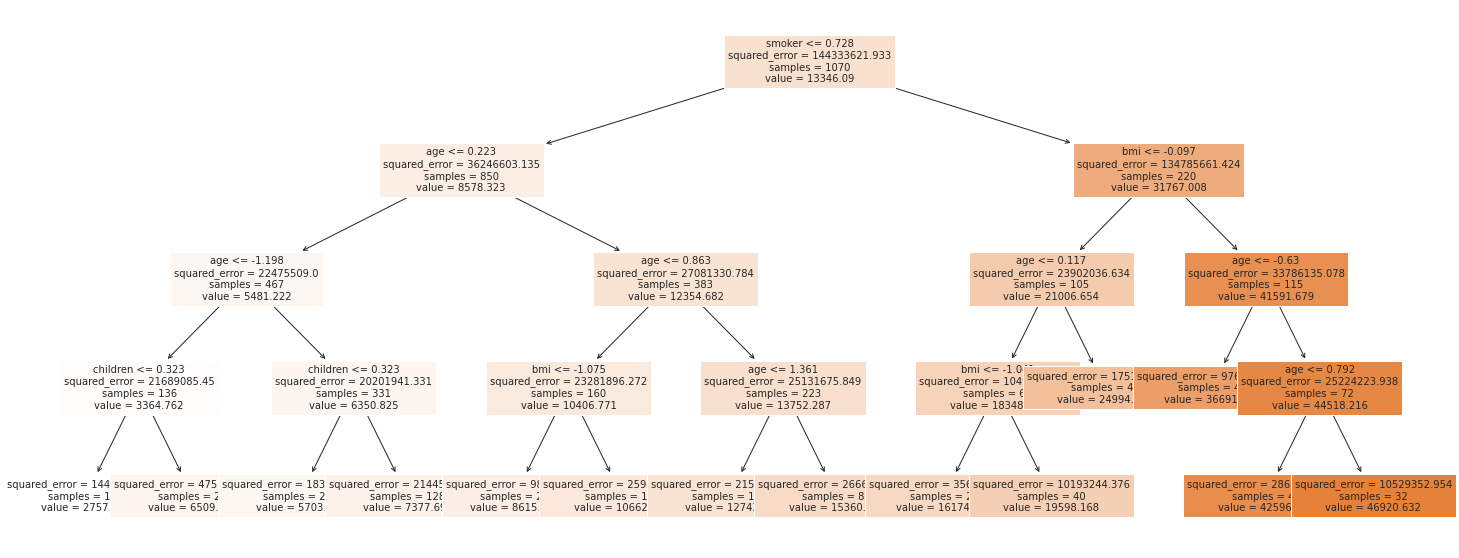

In [ ]:
# We can do a few runs with different max depth for the tree.
# Just change the value below and re-run this cell.
# The model versions you created will show up in the Vectice UI as new versions 
# of the "Regressor" Model. You can easily compare them from there.
tree_depth = 4

# we declare dataset versions to use as inputs of our run
# Since we are inside a git repository, the code tracking is automated.
experiment.start(inputs=[train_ds_version,test_ds_version],
                 run_properties={"Property1": "Value 1", "property2": "Value 2"})


dtr = DecisionTreeRegressor(max_depth=tree_depth, min_samples_split=50)
dtr.fit(X_train,y_train)
dtr_pred = dtr.predict(X_test) 
data_feature_names = ['age','sex', 'bmi', 'children', 'smoker']

# Visualize the Decision Tree Model
plt.figure(figsize=(25, 10))
plot_tree(dtr, feature_names=data_feature_names, filled=True, fontsize=10)
attachment = "DecisionTree_"+str(tree_depth)+".png"
plt.savefig(attachment)
## We can attach the decision tree plot to the model version by using the `attachments` param in the add_model_version method   
MAE = mean_absolute_error(dtr_pred, y_test)
RMSE = sqrt(mean_squared_error(dtr_pred, y_test))
score = dtr.score(X_train,y_train)
print("Root Mean Squared Error:", RMSE)
print("Mean Absolute Error:", MAE)
print("Model Score: ", score.round(2))

hyper_parameters = {"Tree Depth": tree_depth}
metrics = {"MAE": round(MAE, 3), "RMSE": round(RMSE, 3)}

# Let's log the model we trained along with its metrics, as a new version 
# of the "Regressor" model in Vectice.
model_version = experiment.add_model_version(
    model="Regressor",
    algorithm="Decision Tree",
    hyper_parameters=hyper_parameters,
    metrics=metrics,
    attachment=attachment)

# We complete the current experiment's run 
## The created model version will be automatically attached as output of the run
experiment.complete()

### Random forest model

Let's use the Random Forest Regression and do some hyper-parameter tuning on it.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
# You can modify the parameters below and execute multiple runs to train 
## different versions of RF model.
nb_trees = 60
min_samples = 30

# we declare the dataset versions to use as inputs of our run
#Since we are inside a git repository, the code tracking is automated.
experiment.start(inputs=[train_ds_version, test_ds_version],
                run_properties={"Property1": "Value 1", "property2": "Value 2"})

regressor = RandomForestRegressor(n_estimators=nb_trees, min_samples_leaf=min_samples)
regressor.fit(X_train, y_train)
# Predicting a new result
regressor_pred = regressor.predict(X_test)
score = regressor.score(X_train,y_train)

MAE = mean_absolute_error(regressor_pred, y_test)
RMSE = sqrt(mean_squared_error(regressor_pred, y_test))
print("Root Mean Squared Error:", RMSE)
print("Mean Absolute Error:", MAE)
print("Model Score: ", score.round(2))

hyper_parameters = {"nb_trees": nb_trees, "min_samples": min_samples}
metrics = {"MAE": round(MAE, 3), "RMSE": round(RMSE, 3)}

# Let's log the model we trained along with its metrics, as a new version 
# of the "Regressor" model in Vectice.
model_version = experiment.add_model_version(model="Regressor", algorithm="Random Forest",
                                            hyper_parameters=hyper_parameters, metrics=metrics)
# We complete the current experiment's run 
## The created model version will be automatically attached as output of the run
experiment.complete()


We can get the list of the models existing in the project by calling **experiment.list_models()**

In [ ]:
experiment.list_models()

[Model(name=Regressor, id=992, description=Model description, type=ModelType.REGRESSION)]

You can also get all the model versions you created in previous runs, for offline analysis and understanding in more details what's driving the models performance.

In [ ]:
experiment.list_model_versions_dataframe(model = "Regressor")

,createdDate,name,versionNumber,status,algorithmName,isStarred,RMSE,MAE,nb_trees,Tree Depth
0,2022-05-18T14:42:55.083Z,Version 7,7,EXPERIMENTATION,Random Forest,False,NaN,NaN,10,NaN
1,2022-05-18T13:43:19.918Z,Version 6,6,EXPERIMENTATION,Decision Tree,False,4550.170380541586,2884.516334584205,NaN,4
2,2022-05-18T13:42:48.321Z,Version 5,5,EXPERIMENTATION,Decision Tree,False,4550.170380541586,2884.516334584206,NaN,4
3,2022-05-18T13:27:30.218Z,Version 4,4,EXPERIMENTATION,Linear Regression,False,5830.756384113752,4217.2679589761465,NaN,NaN
4,2022-05-18T13:20:14.942Z,Version 3,3,EXPERIMENTATION,Linear Regression,False,5830.756384113755,4217.2679589761665,NaN,NaN
5,2022-05-18T13:20:01.787Z,Version 2,2,EXPERIMENTATION,Linear Regression,False,5830.756384113754,4217.267958976162,NaN,NaN
6,2022-05-18T13:19:33.707Z,Version 1,1,EXPERIMENTATION,Linear Regression,False,5830.756384113754,4217.267958976161,NaN,NaN


We can see that the Random Forest Regressor model gives the lowest error and should be the preferred approach despite the complexity of the algorithm. Let's get the list of features' importance to discuss which variables are influencing the model the most.

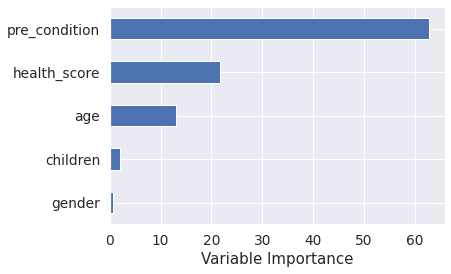

In [ ]:
columns = ['age','gender', 'health_score', 'children', 'pre_condition']

importance = pd.DataFrame({'Importance': regressor.feature_importances_ * 100}, index=columns)
importance.sort_values(by="Importance", axis=0, ascending=True).plot(kind="barh", color="b")
plt.xlabel("Variable Importance")
plt.gca().legend_ = None
plt.savefig("Variable_Importance.png")

#Attach the feature_importance to the model
experiment.add_model_version_attachment(file="Variable_Importance.png", model_version="Version 7", model="Regressor")

Thank you and congratulations! You have succesfully completed this notebook.

In this notebooks we have illustrated how you can capture your experiments, hyper-parameters, dataset versions and metrics using Vectice Python library. 
You can now leverage Vectice UI for analysis, documentation and to engage a business conversation around the findings.

Vectice enables you to:
1. Make your experiments more reproducible.
2. Track the data and code that is used for each experiment and model versions.
3. Document your projects' progress and collaborate with your team in Vectice's UI.
4. Discover previous work and reuse your team knowledge for new projects.

We are constantly improving the Vectice Python library and the Vectice application. Let us know what improvements you would like to see in the solution and what your favorite features are after completing this notebook. 

Feel free to explore more and come up with your own ideas on how to best start leveraging Vectice!
